# **LSTM Fused Decision**

We will create a Fused Decision machine learning architecture to try and best process our data.

Previously, the LSTM model had quite poor performance despite all techniques being employed to prevent overfitting, data imbalance and full hyperparameter tuning and creoss-validation. The data was even re-processed to ensure that there was no data leakage and the train and test set had comparable levels of synthetic data.

Now we will try a slightly different technique whereby we adapt more to the data we have available. We noticed that the sampling frequency of features differ in the 6 hour time window with some features sampled much less than others. Previously, we would resample all data to the same 30 min interval but for features that were rarely observed, this would require a lot of data to be synthesised, meaning the model was likely learning from synthetic patterns which can lead to overfitting.

Now, the data has been processed such that features have been split into subsets based on similar sampling frequencies and each subset has been resampled to a bespoke rate that is better representative of the original data i.e. features that have fewer observations in the original data will be resampeled at a lower rate. This still required a balance between data synthesis and data density as the models require sufficient data to be trained on.

As such, we will create a fused decision system whereby each subset is passed through a separate LSTM model that will be trained to learn from that data and the outputs of each combined to create a fused binary classficaition decision.

In order to limit the model learning from synthetic patterns, where there was no original data for a patient for a specific feature, the value for that has been set to NaN. We will then create a mask around these features that prevents the model learning from this missing data.

The inherent architecture will be eseentially the same as the LSTM employed previously but now with a few extra layers.


**Hyperparameter tuning**

A decision needed to be made regarding whether to have local hyperparameters for each layer or to have a global set of hyperparameters. While having individual hyperparameters for each model would likley help produce the best possible performance, it would require significant computational resources which are not available in this project. As such, we will use a global set of hyperparameters and tune them using Bayesian Optimisation as done previously, noting that future work would likely benefit from more detailed hyperparameter options.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
import itertools
import pickle
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.0 MB/s eta 0:00:00


In [ ]:
import optuna

### **Functions to prepare the dataset**

In [ ]:
class MultiInputTimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for multi-input time series data.
    """
    def __init__(self, low_freq_sequences, low_freq_labels, medium_freq_sequences, medium_freq_labels, high_freq_sequences, high_freq_labels):
        self.low_freq_sequences = low_freq_sequences
        self.low_freq_labels = low_freq_labels
        self.medium_freq_sequences = medium_freq_sequences
        self.medium_freq_labels = medium_freq_labels
        self.high_freq_sequences = high_freq_sequences
        self.high_freq_labels = high_freq_labels

    def __len__(self):
        return max(len(self.low_freq_sequences), len(self.medium_freq_sequences), len(self.high_freq_sequences))

    def __getitem__(self, idx):
        low_seq = torch.tensor(self.low_freq_sequences[idx], dtype=torch.float32) if idx < len(self.low_freq_sequences) else torch.zeros((6, 5))
        low_label = torch.tensor(self.low_freq_labels[idx], dtype=torch.float32) if idx < len(self.low_freq_labels) else torch.tensor(0, dtype=torch.float32)

        medium_seq = torch.tensor(self.medium_freq_sequences[idx], dtype=torch.float32) if idx < len(self.medium_freq_sequences) else torch.zeros((12, 10))
        medium_label = torch.tensor(self.medium_freq_labels[idx], dtype=torch.float32) if idx < len(self.medium_freq_labels) else torch.tensor(0, dtype=torch.float32)

        high_seq = torch.tensor(self.high_freq_sequences[idx], dtype=torch.float32) if idx < len(self.high_freq_sequences) else torch.zeros((24, 15))
        high_label = torch.tensor(self.high_freq_labels[idx], dtype=torch.float32) if idx < len(self.high_freq_labels) else torch.tensor(0, dtype=torch.float32)

        return {
            'low_freq_sequence': low_seq,
            'low_freq_label': low_label,
            'medium_freq_sequence': medium_seq,
            'medium_freq_label': medium_label,
            'high_freq_sequence': high_seq,
            'high_freq_label': high_label
        }

In [ ]:
def create_multi_input_data_loaders(low_freq_train_sequences, low_freq_train_labels,
                                    medium_freq_train_sequences, medium_freq_train_labels,
                                    high_freq_train_sequences, high_freq_train_labels,
                                    low_freq_val_sequences, low_freq_val_labels,
                                    medium_freq_val_sequences, medium_freq_val_labels,
                                    high_freq_val_sequences, high_freq_val_labels,
                                    low_freq_test_sequences, low_freq_test_labels,
                                    medium_freq_test_sequences, medium_freq_test_labels,
                                    high_freq_test_sequences, high_freq_test_labels,
                                    batch_size):
    """
    Creates PyTorch DataLoader objects for training, validation, and test sets with multiple inputs.

    Args:
        low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences: Training sequences.
        low_freq_train_labels, medium_freq_train_labels, high_freq_train_labels: Training labels.
        low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences: Validation sequences.
        low_freq_val_labels, medium_freq_val_labels, high_freq_val_labels: Validation labels.
        low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences: Test sequences.
        low_freq_test_labels, medium_freq_test_labels, high_freq_test_labels: Test labels.
        batch_size: Batch size for the DataLoaders.

    Returns:
        tuple: A tuple containing the train, validation, and test DataLoaders.
    """
    train_dataset = MultiInputTimeSeriesDataset(low_freq_train_sequences, low_freq_train_labels,
                                                medium_freq_train_sequences, medium_freq_train_labels,
                                                high_freq_train_sequences, high_freq_train_labels)
    val_dataset = MultiInputTimeSeriesDataset(low_freq_val_sequences, low_freq_val_labels,
                                              medium_freq_val_sequences, medium_freq_val_labels,
                                              high_freq_val_sequences, high_freq_val_labels)
    test_dataset = MultiInputTimeSeriesDataset(low_freq_test_sequences, low_freq_test_labels,
                                               medium_freq_test_sequences, medium_freq_test_labels,
                                               high_freq_test_sequences, high_freq_test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

Since each set of patients has different shapes / lengths it is not feasible to create one data loader that can stack all datasets together. Hence, we will try creating separate data loaders for each data subset.

In [ ]:
class TimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for time series data.

    Args:
        sequences (numpy.ndarray): A NumPy array containing time series sequences.
        labels (numpy.ndarray): A NumPy array containing the corresponding labels for the sequences.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary containing the time series sequence and label for the given index.
    """
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.sequences)

    def __getitem__(self, idx):
        """
        Returns a dictionary containing the time series sequence and label for the given index.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            dict: A dictionary with keys 'sequence' and 'label', containing the time series sequence and label tensors, respectively.
        """
        return {
            'sequence': torch.tensor(self.sequences[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_separate_data_loaders(low_freq_train_sequences, low_freq_train_labels,
                                 medium_freq_train_sequences, medium_freq_train_labels,
                                 high_freq_train_sequences, high_freq_train_labels,
                                 low_freq_val_sequences, low_freq_val_labels,
                                 medium_freq_val_sequences, medium_freq_val_labels,
                                 high_freq_val_sequences, high_freq_val_labels,
                                 low_freq_test_sequences, low_freq_test_labels,
                                 medium_freq_test_sequences, medium_freq_test_labels,
                                 high_freq_test_sequences, high_freq_test_labels,
                                 batch_size):
    """
    Creates separate PyTorch DataLoader objects for training, validation, and test sets for each frequency subset.

    Args:
        low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences: Training sequences.
        low_freq_train_labels, medium_freq_train_labels, high_freq_train_labels: Training labels.
        low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences: Validation sequences.
        low_freq_val_labels, medium_freq_val_labels, high_freq_val_labels: Validation labels.
        low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences: Test sequences.
        low_freq_test_labels, medium_freq_test_labels, high_freq_test_labels: Test labels.
        batch_size: Batch size for the DataLoaders.

    Returns:
        tuple: A tuple containing separate train, validation, and test DataLoaders for each subset.
    """
    low_train_loader = DataLoader(TimeSeriesDataset(low_freq_train_sequences, low_freq_train_labels), batch_size=batch_size, shuffle=True)
    medium_train_loader = DataLoader(TimeSeriesDataset(medium_freq_train_sequences, medium_freq_train_labels), batch_size=batch_size, shuffle=True)
    high_train_loader = DataLoader(TimeSeriesDataset(high_freq_train_sequences, high_freq_train_labels), batch_size=batch_size, shuffle=True)

    low_val_loader = DataLoader(TimeSeriesDataset(low_freq_val_sequences, low_freq_val_labels), batch_size=batch_size, shuffle=False)
    medium_val_loader = DataLoader(TimeSeriesDataset(medium_freq_val_sequences, medium_freq_val_labels), batch_size=batch_size, shuffle=False)
    high_val_loader = DataLoader(TimeSeriesDataset(high_freq_val_sequences, high_freq_val_labels), batch_size=batch_size, shuffle=False)

    low_test_loader = DataLoader(TimeSeriesDataset(low_freq_test_sequences, low_freq_test_labels), batch_size=batch_size, shuffle=False)
    medium_test_loader = DataLoader(TimeSeriesDataset(medium_freq_test_sequences, medium_freq_test_labels), batch_size=batch_size, shuffle=False)
    high_test_loader = DataLoader(TimeSeriesDataset(high_freq_test_sequences, high_freq_test_labels), batch_size=batch_size, shuffle=False)

    return (low_train_loader, medium_train_loader, high_train_loader), (low_val_loader, medium_val_loader, high_val_loader), (low_test_loader, medium_test_loader, high_test_loader)

### **Define Sampling Methods**

In [ ]:
def undersample_data(low_sequences, low_labels, medium_sequences, medium_labels, high_sequences, high_labels):
    """
    Undersamples the data using RandomUnderSampler for each frequency subset.

    Args:
        low_sequences (numpy.ndarray): Low frequency sequences.
        low_labels (numpy.ndarray): Corresponding labels for low frequency sequences.
        medium_sequences (numpy.ndarray): Medium frequency sequences.
        medium_labels (numpy.ndarray): Corresponding labels for medium frequency sequences.
        high_sequences (numpy.ndarray): High frequency sequences.
        high_labels (numpy.ndarray): Corresponding labels for high frequency sequences.

    Returns:
        tuple: Undersampled sequences and labels for low, medium, and high frequency data.
    """
    rus = RandomUnderSampler()

    def undersample(sequences, labels):
        sequences_flat = sequences.reshape(sequences.shape[0], -1)
        sequences_resampled, labels_resampled = rus.fit_resample(sequences_flat, labels)
        sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
        return sequences_resampled, labels_resampled

    low_sequences_resampled, low_labels_resampled = undersample(low_sequences, low_labels)
    medium_sequences_resampled, medium_labels_resampled = undersample(medium_sequences, medium_labels)
    high_sequences_resampled, high_labels_resampled = undersample(high_sequences, high_labels)

    return low_sequences_resampled, low_labels_resampled, medium_sequences_resampled, medium_labels_resampled, high_sequences_resampled, high_labels_resampled

In [ ]:
def oversample_data(low_sequences, low_labels, medium_sequences, medium_labels, high_sequences, high_labels):
    """
    Oversamples the data using SMOTE for each frequency subset.

    Args:
        low_sequences (numpy.ndarray): Low frequency sequences.
        low_labels (numpy.ndarray): Corresponding labels for low frequency sequences.
        medium_sequences (numpy.ndarray): Medium frequency sequences.
        medium_labels (numpy.ndarray): Corresponding labels for medium frequency sequences.
        high_sequences (numpy.ndarray): High frequency sequences.
        high_labels (numpy.ndarray): Corresponding labels for high frequency sequences.

    Returns:
        tuple: Oversampled sequences and labels for low, medium, and high frequency data.
    """
    smote = SMOTE()

    def oversample(sequences, labels):
        sequences_flat = sequences.reshape(sequences.shape[0], -1)
        sequences_resampled, labels_resampled = smote.fit_resample(sequences_flat, labels)
        sequences_resampled = sequences_resampled.reshape((sequences_resampled.shape[0], sequences.shape[1], sequences.shape[2]))
        return sequences_resampled, labels_resampled

    low_sequences_resampled, low_labels_resampled = oversample(low_sequences, low_labels)
    medium_sequences_resampled, medium_labels_resampled = oversample(medium_sequences, medium_labels)
    high_sequences_resampled, high_labels_resampled = oversample(high_sequences, high_labels)

    return low_sequences_resampled, low_labels_resampled, medium_sequences_resampled, medium_labels_resampled, high_sequences_resampled, high_labels_resampled

### **Define the Fused LSTM architecture**

In [ ]:
class FusedLSTMModel(nn.Module):
    """
    A fused LSTM model for sequence classification and handles masking.

    """
    def __init__(self, low_input_dim, medium_input_dim, high_input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
      super(FusedLSTMModel, self).__init__()
      self.hidden_dim = hidden_dim
      self.layer_dim = layer_dim

      if layer_dim == 1:
        dropout_prob = 0.0

      # Define the LSTM layers
      self.low_lstm = nn.LSTM(low_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.medium_lstm = nn.LSTM(medium_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.high_lstm = nn.LSTM(high_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

      # Define the fully connected layer to fuse outputs
      self.fc = nn.Linear(hidden_dim * 3, output_dim)

      # Define sigmoid for binary classification
      self.sigmoid = nn.Sigmoid()

    def forward(self, low_x, medium_x, high_x):
      # Create masks and handle NaNs
      low_mask = ~low_x.isnan()
      medium_mask = ~medium_x.isnan()
      high_mask = ~high_x.isnan()

      # Set NaNs to zeroes to be passed through model
      low_x = torch.where(low_mask, low_x, torch.zeros_like(low_x))
      medium_x = torch.where(medium_mask, medium_x, torch.zeros_like(medium_x))
      high_x = torch.where(high_mask, high_x, torch.zeros_like(high_x))

      # Initial hidden and cell states
      h0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)
      c0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)

      h0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)
      c0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)

      h0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)
      c0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)

      # Forward pass through LSTM layers
      low_out, _ = self.low_lstm(low_x, (h0_low, c0_low))
      medium_out, _ = self.medium_lstm(medium_x, (h0_medium, c0_medium))
      high_out, _ = self.high_lstm(high_x, (h0_high, c0_high))

      # Ensure masks are the same shape as the LSTM outputs
      low_mask = low_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, low_out.shape[-1])
      medium_mask = medium_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, medium_out.shape[-1])
      high_mask = high_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, high_out.shape[-1])

      # Apply masks to the LSTM outputs by zeroing out invalid positions
      low_out = low_out * low_mask.float()
      medium_out = medium_out * medium_mask.float()
      high_out = high_out * high_mask.float()

      # Get the last valid output for each sequence
      def get_last_valid_output(output, mask):
        last_valid_index = mask.sum(dim=1) - 1
        last_valid_index = last_valid_index.unsqueeze(1).unsqueeze(2).expand(-1, 1, output.size(-1))
        return output.gather(1, last_valid_index).squeeze(1)

      low_out_last = get_last_valid_output(low_out, low_mask[:, :, 0])
      medium_out_last = get_last_valid_output(medium_out, medium_mask[:, :, 0])
      high_out_last = get_last_valid_output(high_out, high_mask[:, :, 0])

      # Concatenate the outputs
      out = torch.cat((low_out_last, medium_out_last, high_out_last), dim=1)

      # Apply the fully connected layer to fuse outputs
      out = self.fc(out)

      # Apply sigmoid for binary classification
      out = self.sigmoid(out)

      return out

### **Define Early stopping logic**

In [ ]:
class EarlyStopping:
    """
    Early stops the training if the average validation AUC across all subsets doesn't improve after a given patience.

    Args:
        output_path (str): Path to save the best model checkpoint.
        patience (int, optional): How long to wait after the last time the validation AUC improved. Defaults to 5.
        min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement. Defaults to 0.
    """
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc_dict, model):
        """
        Checks the average validation AUC and decides whether to stop training.

        Args:
            val_auc_dict (dict): Dictionary containing validation AUC scores for each subset.
            model (torch.nn.Module): The model being trained.
        """
        avg_val_auc = sum(val_auc_dict.values()) / len(val_auc_dict)

        if self.best_score is None:
            self.best_score = avg_val_auc
            self.save_checkpoint(model)
        elif avg_val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = avg_val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """
        Saves the model checkpoint.

        Args:
            model (torch.nn.Module): The model to save.
        """
        torch.save(model.state_dict(), self.output_path)

### **Define function to train mdoel with validation sets**

In [ ]:
def train_fused_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the fused LSTM model with early stopping and logging.

    Parameters:
    model (nn.Module): The fused LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (dict): Dictionary of validation AUC scores per epoch for each subset.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)

    train_losses = []
    val_losses = []
    val_aucs = {'low': [], 'medium': [], 'high': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['low_freq_label'].to(device).view(-1, 1)  # Use low_freq_label for training

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = {'low': [], 'medium': [], 'high': []}
        val_labels = {'low': [], 'medium': [], 'high': []}

        with torch.no_grad():
            for data in val_loader:
                low_freq_sequences = data['low_freq_sequence'].to(device)
                medium_freq_sequences = data['medium_freq_sequence'].to(device)
                high_freq_sequences = data['high_freq_sequence'].to(device)
                low_labels = data['low_freq_label'].to(device).view(-1, 1)
                medium_labels = data['medium_freq_label'].to(device).view(-1, 1)
                high_labels = data['high_freq_label'].to(device).view(-1, 1)

                outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
                loss = criterion(outputs, low_labels)  # Use low_freq_label for validation loss calculation
                val_running_loss += loss.item() * low_freq_sequences.size(0)

                val_outputs['low'].extend(outputs.cpu().numpy())
                val_labels['low'].extend(low_labels.cpu().numpy())
                val_outputs['medium'].extend(outputs.cpu().numpy())
                val_labels['medium'].extend(medium_labels.cpu().numpy())
                val_outputs['high'].extend(outputs.cpu().numpy())
                val_labels['high'].extend(high_labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_auc_dict = {key: roc_auc_score(val_labels[key], val_outputs[key]) for key in val_outputs}
        for key in val_auc_dict:
            val_aucs[key].append(val_auc_dict[key])

        early_stopping(val_auc_dict, model)

        avg_val_auc = sum(val_auc_dict.values()) / len(val_auc_dict)
        if avg_val_auc > best_auc:
            best_auc = avg_val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Avg Val AUC: {avg_val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

### **Implement cross validation**

In [ ]:
def shuffle_data(sequences, labels):
        assert len(sequences) == len(labels)
        p = np.random.permutation(len(sequences))
        return sequences[p], labels[p]

def split_data_into_folds(sequences, labels, num_folds):
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(sequences)
        else:
            end_idx = start_idx + fold_size
        sequences_folds.append(sequences[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return sequences_folds, labels_folds

In [ ]:
def reset_model(model):
    """
    Reset the parameters of the model to their initial values.

    Parameters:
    model (nn.Module): The model whose parameters need to be reset.
    """
    def reset_parameters(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    # Iterate over each module in the model and reset parameters if possible
    for layer in model.children():
        if isinstance(layer, nn.Module):
            reset_parameters(layer)
            # Recursively reset parameters for any sub-modules
            for sub_layer in layer.children():
                reset_parameters(sub_layer)

In [ ]:
def manual_cross_validation(low_sequences, low_labels, medium_sequences, medium_labels, high_sequences, high_labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    """
    Perform manual cross-validation for the fused LSTM model.

    Parameters:
    low_sequences (np.array): Low frequency sequences.
    low_labels (np.array): Labels for low frequency sequences.
    medium_sequences (np.array): Medium frequency sequences.
    medium_labels (np.array): Labels for medium frequency sequences.
    high_sequences (np.array): High frequency sequences.
    high_labels (np.array): Labels for high frequency sequences.
    hyperparameters (list): List of hyperparameter dictionaries to evaluate.
    num_folds (int): Number of folds for cross-validation. Default is 5.
    patience (int): Number of epochs to wait for improvement before stopping early. Default is 5.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    tuple: Best model, best hyperparameters, best AUC score.
    """
    def shuffle_data(sequences, labels):
        assert len(sequences) == len(labels)
        p = np.random.permutation(len(sequences))
        return sequences[p], labels[p]

    def split_data_into_folds(sequences, labels, num_folds):
        fold_size = len(sequences) // num_folds
        sequences_folds = []
        labels_folds = []
        for i in range(num_folds):
            start_idx = i * fold_size
            if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
                end_idx = len(sequences)
            else:
                end_idx = start_idx + fold_size
            sequences_folds.append(sequences[start_idx:end_idx])
            labels_folds.append(labels[start_idx:end_idx])
        return sequences_folds, labels_folds

    # Shuffle and split the data into folds
    low_sequences, low_labels = shuffle_data(low_sequences, low_labels)
    medium_sequences, medium_labels = shuffle_data(medium_sequences, medium_labels)
    high_sequences, high_labels = shuffle_data(high_sequences, high_labels)

    low_sequences_folds, low_labels_folds = split_data_into_folds(low_sequences, low_labels, num_folds)
    medium_sequences_folds, medium_labels_folds = split_data_into_folds(medium_sequences, medium_labels, num_folds)
    high_sequences_folds, high_labels_folds = split_data_into_folds(high_sequences, high_labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        # Separate into train and validation sets
        val_low_sequences = low_sequences_folds[i]
        val_low_labels = low_labels_folds[i]
        train_low_sequences = np.concatenate([low_sequences_folds[j] for j in range(num_folds) if j != i])
        train_low_labels = np.concatenate([low_labels_folds[j] for j in range(num_folds) if j != i])

        val_medium_sequences = medium_sequences_folds[i]
        val_medium_labels = medium_labels_folds[i]
        train_medium_sequences = np.concatenate([medium_sequences_folds[j] for j in range(num_folds) if j != i])
        train_medium_labels = np.concatenate([medium_labels_folds[j] for j in range(num_folds) if j != i])

        val_high_sequences = high_sequences_folds[i]
        val_high_labels = high_labels_folds[i]
        train_high_sequences = np.concatenate([high_sequences_folds[j] for j in range(num_folds) if j != i])
        train_high_labels = np.concatenate([high_labels_folds[j] for j in range(num_folds) if j != i])

        for params in hyperparameters:
            # Handle sampling methods
            if params['sampling_method'] == 'undersample':
                train_low_sequences_resampled, train_low_labels_resampled, train_medium_sequences_resampled, train_medium_labels_resampled, train_high_sequences_resampled, train_high_labels_resampled = undersample_data(
                    train_low_sequences, train_low_labels,
                    train_medium_sequences, train_medium_labels,
                    train_high_sequences, train_high_labels
                )
            elif params['sampling_method'] == 'oversample':
                train_low_sequences_resampled, train_low_labels_resampled, train_medium_sequences_resampled, train_medium_labels_resampled, train_high_sequences_resampled, train_high_labels_resampled = oversample_data(
                    train_low_sequences, train_low_labels,
                    train_medium_sequences, train_medium_labels,
                    train_high_sequences, train_high_labels
                )
            else:
                train_low_sequences_resampled, train_low_labels_resampled = train_low_sequences, train_low_labels
                train_medium_sequences_resampled, train_medium_labels_resampled = train_medium_sequences, train_medium_labels
                train_high_sequences_resampled, train_high_labels_resampled = train_high_sequences, train_high_labels

            # Create data loaders for each subset using the provided function
            train_loader, val_loader, _ = create_multi_input_data_loaders(
                train_low_sequences_resampled, train_low_labels_resampled,
                train_medium_sequences_resampled, train_medium_labels_resampled,
                train_high_sequences_resampled, train_high_labels_resampled,
                val_low_sequences, val_low_labels,
                val_medium_sequences, val_medium_labels,
                val_high_sequences, val_high_labels,
                val_low_sequences, val_low_labels,  # Use val data as test data placeholder
                val_medium_sequences, val_medium_labels,  # Use val data as test data placeholder
                val_high_sequences, val_high_labels,  # Use val data as test data placeholder
                batch_size=params['batch_size']
            )

            # Determine the input_dim for each subset
            low_input_dim = train_low_sequences.shape[2]
            medium_input_dim = train_medium_sequences.shape[2]
            high_input_dim = train_high_sequences.shape[2]

            # Initialize the model
            model = FusedLSTMModel(
                low_input_dim=low_input_dim,
                medium_input_dim=medium_input_dim,
                high_input_dim=high_input_dim,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,
                dropout_prob=params['dropout_prob']
            ).to(device)

            # Define the loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_low_labels_resampled) / (2.0 * sum(train_low_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            # Define the optimizer with learning rate and L2 weight decay
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_fused_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = {'low': [], 'medium': [], 'high': []}
            val_labels = {'low': [], 'medium': [], 'high': []}
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    low_freq_sequences = data['low_freq_sequence'].to(device)
                    medium_freq_sequences = data['medium_freq_sequence'].to(device)
                    high_freq_sequences = data['high_freq_sequence'].to(device)
                    low_labels = data['low_freq_label'].to(device).view(-1, 1)
                    medium_labels = data['medium_freq_label'].to(device).view(-1, 1)
                    high_labels = data['high_freq_label'].to(device).view(-1, 1)
                    outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

                    val_outputs['low'].extend(outputs.cpu().numpy().flatten())
                    val_labels['low'].extend(low_labels.cpu().numpy().flatten())
                    val_outputs['medium'].extend(outputs.cpu().numpy().flatten())
                    val_labels['medium'].extend(medium_labels.cpu().numpy().flatten())
                    val_outputs['high'].extend(outputs.cpu().numpy().flatten())
                    val_labels['high'].extend(high_labels.cpu().numpy().flatten())

            val_auc = roc_auc_score(np.concatenate([val_labels['low'], val_labels['medium'], val_labels['high']]),
                                    np.concatenate([val_outputs['low'], val_outputs['medium'], val_outputs['high']]))
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(16, 6))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses['low'], 'r-', label='Low frequency validation loss')
        plt.plot(epochs, best_val_losses['medium'], 'g-', label='Medium frequency validation loss')
        plt.plot(epochs, best_val_losses['high'], 'y-', label='High frequency validation loss')
        avg_val_loss = [(best_val_losses['low'][i] + best_val_losses['medium'][i] + best_val_losses['high'][i]) / 3 for i in range(len(epochs))]
        plt.plot(epochs, avg_val_loss, 'm-', label='Average validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation AUC for each subset
        plt.subplot(1, 2, 2)
        plt.plot(epochs, best_val_aucs['low'], 'r-', label='Low frequency validation AUC')
        plt.plot(epochs, best_val_aucs['medium'], 'g-', label='Medium frequency validation AUC')
        plt.plot(epochs, best_val_aucs['high'], 'y-', label='High frequency validation AUC')
        avg_val_auc = [(best_val_aucs['low'][i] + best_val_aucs['medium'][i] + best_val_aucs['high'][i]) / 3 for i in range(len(epochs))]
        plt.plot(epochs, avg_val_auc, 'c-', label='Average validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc

### **Define Bayesian Optimisation objective function**

In [ ]:
def objective_wrapper(low_train_sequences, low_train_labels, medium_train_sequences, medium_train_labels, high_train_sequences, high_train_labels, hyperparameter_grid):
    """
    Wrapper function for the Optuna objective.

    Parameters:
    low_train_sequences (np.array): Low frequency training sequences.
    low_train_labels (np.array): Labels for low frequency training sequences.
    medium_train_sequences (np.array): Medium frequency training sequences.
    medium_train_labels (np.array): Labels for medium frequency training sequences.
    high_train_sequences (np.array): High frequency training sequences.
    high_train_labels (np.array): Labels for high frequency training sequences.
    hyperparameter_grid (dict): Dictionary containing hyperparameters and their possible values.

    Returns:
    function: Optuna objective function.
    """
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', hyperparameter_grid['hidden_dim'])
        layer_dim = trial.suggest_categorical('layer_dim', hyperparameter_grid['layer_dim'])
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_categorical('num_epochs', hyperparameter_grid['num_epochs'])
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            low_train_sequences, low_train_labels,
            medium_train_sequences, medium_train_labels,
            high_train_sequences, high_train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

### **Run the model on dummy data**

We will first test that the model runs on dummy data with Bayesian Optimisation.

In [ ]:
param_grid = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

In [ ]:
# Generate dummy data
def generate_dummy_data(num_samples, sequence_length, num_features):
    sequences = np.random.randn(num_samples, sequence_length, num_features).astype(np.float32)
    labels = np.random.randint(0, 2, size=(num_samples, 1)).astype(np.float32)
    return sequences, labels

low_freq_train_sequences, low_freq_train_labels = generate_dummy_data(100, 6, 5)
medium_freq_train_sequences, medium_freq_train_labels = generate_dummy_data(100, 12, 10)
high_freq_train_sequences, high_freq_train_labels = generate_dummy_data(100, 24, 15)

[I 2024-07-29 08:21:36,007] A new study created in memory with name: no-name-709cc883-d0fa-4df9-aa6f-a744ddefe048


Epoch 0/49, Loss: 2.0788, Val Loss: {'low': [0.23504018783569336], 'medium': [0.2297780712445577], 'high': [0.2315029501914978]}, Avg Val AUC: 0.5156
Epoch 1/49, Loss: 2.0795, Val Loss: {'low': [0.23504018783569336, 0.23315048217773438], 'medium': [0.2297780712445577, 0.230241596698761], 'high': [0.2315029501914978, 0.23114357391993204]}, Avg Val AUC: 0.5350
Epoch 2/49, Loss: 2.0780, Val Loss: {'low': [0.23504018783569336, 0.23315048217773438, 0.23169962565104166], 'medium': [0.2297780712445577, 0.230241596698761, 0.23078304529190063], 'high': [0.2315029501914978, 0.23114357391993204, 0.23097378015518188]}, Avg Val AUC: 0.5448
Epoch 3/49, Loss: 2.0780, Val Loss: {'low': [0.23504018783569336, 0.23315048217773438, 0.23169962565104166, 0.2315846085548401], 'medium': [0.2297780712445577, 0.230241596698761, 0.23078304529190063, 0.23084201415379843], 'high': [0.2315029501914978, 0.23114357391993204, 0.23097378015518188, 0.2309130628903707]}, Avg Val AUC: 0.5580
Epoch 4/49, Loss: 2.0783, Val 

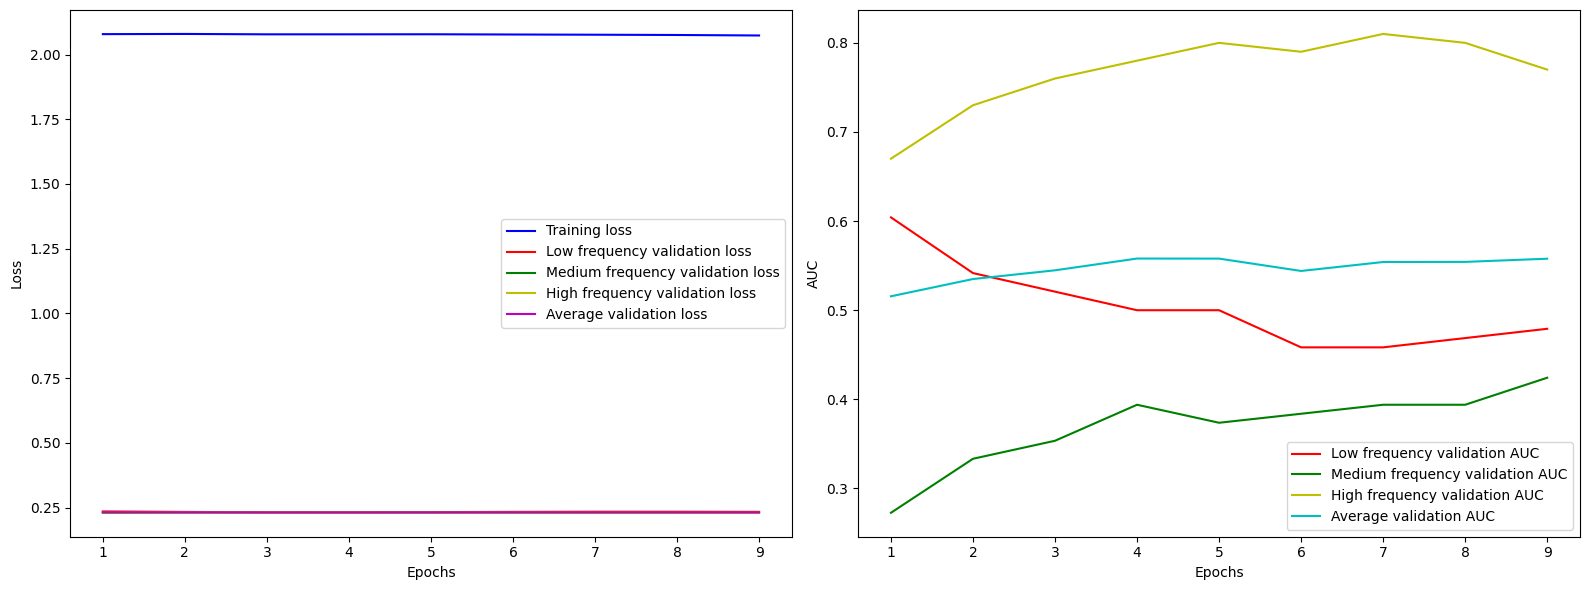

[I 2024-07-29 08:21:39,894] Trial 0 finished with value: -0.5583982202447163 and parameters: {'hidden_dim': 256, 'layer_dim': 4, 'dropout_prob': 0.25, 'learning_rate': 0.001, 'batch_size': 128, 'num_epochs': 50, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.0001}. Best is trial 0 with value: -0.5583982202447163.


Epoch 0/9, Loss: 2.0795, Val Loss: {'low': [0.23108561833699545], 'medium': [0.23097153504689535], 'high': [0.23094338178634644]}, Avg Val AUC: 0.5201
Epoch 1/9, Loss: 2.0794, Val Loss: {'low': [0.23108561833699545, 0.2310886780420939], 'medium': [0.23097153504689535, 0.23095025618871054], 'high': [0.23094338178634644, 0.230901300907135]}, Avg Val AUC: 0.5200
Epoch 2/9, Loss: 2.0794, Val Loss: {'low': [0.23108561833699545, 0.2310886780420939, 0.23109185695648193], 'medium': [0.23097153504689535, 0.23095025618871054, 0.2309291958808899], 'high': [0.23094338178634644, 0.230901300907135, 0.23085949818293253]}, Avg Val AUC: 0.5234
Epoch 3/9, Loss: 2.0793, Val Loss: {'low': [0.23108561833699545, 0.2310886780420939, 0.23109185695648193, 0.23109513521194458], 'medium': [0.23097153504689535, 0.23095025618871054, 0.2309291958808899, 0.23090829451878866], 'high': [0.23094338178634644, 0.230901300907135, 0.23085949818293253, 0.23081799348195395]}, Avg Val AUC: 0.5269
Epoch 4/9, Loss: 2.0792, Val 

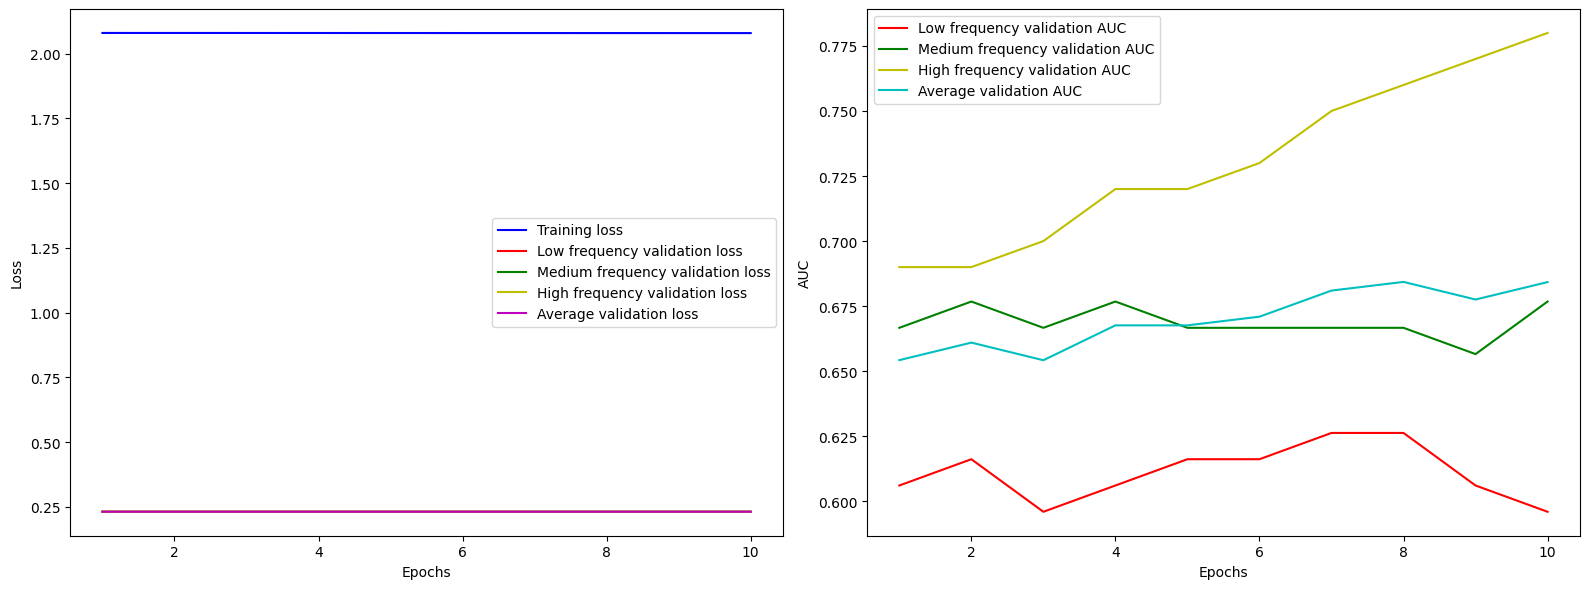

[I 2024-07-29 08:21:42,783] Trial 1 finished with value: -0.6833333333333333 and parameters: {'hidden_dim': 256, 'layer_dim': 3, 'dropout_prob': 0.0, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 10, 'sampling_method': 'oversample', 'loss': 'normal', 'weight_decay': 1e-05}. Best is trial 1 with value: -0.6833333333333333.


In [ ]:
dummy_study = optuna.create_study(direction='minimize')
dummy_study.optimize(objective_wrapper(
    low_freq_train_sequences, low_freq_train_labels,
    medium_freq_train_sequences, medium_freq_train_labels,
    high_freq_train_sequences, high_freq_train_labels,
    param_grid
), n_trials=2)

The model seems to run without any runtime errors, thus we can try using it with the actual data.

# **Load the data**

In [ ]:
# Load the data
low_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets/low_frequency_train_sequences_v1.npy'
low_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets/low_frequency_train_labels_v1.npy'
medium_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets/medium_frequency_train_sequences_v1.npy'
medium_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets/medium_frequency_train_labels_v1.npy'
high_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets/high_frequency_train_sequences_v1.npy'
high_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets/high_frequency_train_labels_v1.npy'

low_freq_train_sequences = np.load(low_train_path, allow_pickle=True).astype(np.float32)
low_freq_train_labels = np.load(low_labels_path, allow_pickle=True).astype(np.float32)
medium_freq_train_sequences = np.load(medium_train_path, allow_pickle=True).astype(np.float32)
medium_freq_train_labels = np.load(medium_labels_path, allow_pickle=True).astype(np.float32)
high_freq_train_sequences = np.load(high_train_path, allow_pickle=True).astype(np.float32)
high_freq_train_labels = np.load(high_labels_path, allow_pickle=True).astype(np.float32)

print(f'Low frequency train sequences shape: {low_freq_train_sequences.shape}')
print(f'Low frequency train labels shape: {low_freq_train_labels.shape}')
print(f'Medium frequency train sequences shape: {medium_freq_train_sequences.shape}')
print(f'Medium frequency train labels shape: {medium_freq_train_labels.shape}')
print(f'High frequency train sequences shape: {high_freq_train_sequences.shape}')
print(f'High frequency train labels shape: {high_freq_train_labels.shape}')

# **Experiment 1**

We can now commence hyperparameter tuning using Bayesian Optimisation.

As we have decided to maintain a global set of hyperparameters for computational efficiency, we will use the same extensive parameter grid defined in the previous LSTM experimentation.

**Define the hyperparameter grid**

In [ ]:
param_grid = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

param_combinations = list(itertools.product(*param_grid.values()))

param_combinations = [
    dict(zip(param_grid.keys(), combination))
    for combination in param_combinations
]

print(f"Number of parameter combinations: {len(param_combinations)}")

Number of parameter combinations: 153600


**Define the Baysian Optimisation function to maximise the ROCAUC**

In [ ]:
def objective_wrapper(low_train_sequences, low_train_labels, medium_train_sequences,
                      medium_train_labels, high_train_sequences, high_train_labels, hyperparameter_grid):
    """
    Wrapper function for the Optuna objective.

    Parameters:
    low_train_sequences (np.array): Low frequency training sequences.
    low_train_labels (np.array): Labels for low frequency training sequences.
    medium_train_sequences (np.array): Medium frequency training sequences.
    medium_train_labels (np.array): Labels for medium frequency training sequences.
    high_train_sequences (np.array): High frequency training sequences.
    high_train_labels (np.array): Labels for high frequency training sequences.
    hyperparameter_grid (dict): Dictionary containing hyperparameters and their possible values.

    Returns:
    function: Optuna objective function.
    """
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', hyperparameter_grid['hidden_dim'])
        layer_dim = trial.suggest_categorical('layer_dim', hyperparameter_grid['layer_dim'])
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_categorical('num_epochs', hyperparameter_grid['num_epochs'])
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            low_train_sequences, low_train_labels,
            medium_train_sequences, medium_train_labels,
            high_train_sequences, high_train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Run Bayesian Optimisation with 100 trials**

In [ ]:
# Run Bayesian Optimisation with 100 trials
study_exp_1 = optuna.create_study(direction='minimize')
study_exp_1.optimize(objective_wrapper(
    low_freq_train_sequences, low_freq_train_labels,
    medium_freq_train_sequences, medium_freq_train_labels,
    high_freq_train_sequences, high_freq_train_labels,
    param_grid
), n_trials=10)

# Identify the best hyperparameters and value
best_params = study_exp_1.best_params
best_value = study_exp_1.best_value

# Print the best params and value
print(f"Best parameters: {best_params}")
print(f"Best value: {best_value}")

# **Addendum**

It seemed the majority of errors we are getting are due to the subsets containing different combinations of patients.

As such, the model does not have consistent labels to calculate the loss as each subset had different training labels - making model architecture quite complicated.

To fix this, we have ensured all patients are represented in all subsets. Where data was missing originally, the sequence for that feature for that patient was filled with NaNs to be masked. As such, all subsets have the same set of labels

# **Experiment 2**

We will now load and pass this data through to train the model.

We will need to redefine the model architecture to be able to handle the new data structure as we no longer need to have separate labels.

In [ ]:
class MultiInputTimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for time series data with multiple input sequences.

    Args:
        low_sequences (numpy.ndarray): Low-frequency sequences.
        medium_sequences (numpy.ndarray): Medium-frequency sequences.
        high_sequences (numpy.ndarray): High-frequency sequences.
        labels (numpy.ndarray): Corresponding labels for the sequences.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary containing the sequences and label for the given index.
    """
    def __init__(self, low_sequences, medium_sequences, high_sequences, labels):
        self.low_sequences = low_sequences
        self.medium_sequences = medium_sequences
        self.high_sequences = high_sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'low_freq_sequence': torch.tensor(self.low_sequences[idx], dtype=torch.float32),
            'medium_freq_sequence': torch.tensor(self.medium_sequences[idx], dtype=torch.float32),
            'high_freq_sequence': torch.tensor(self.high_sequences[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_multi_input_data_loaders(low_freq_train_sequences,
                                    medium_freq_train_sequences,
                                    high_freq_train_sequences,
                                    train_labels,
                                    low_freq_val_sequences,
                                    medium_freq_val_sequences,
                                    high_freq_val_sequences,
                                    val_labels,
                                    low_freq_test_sequences,
                                    medium_freq_test_sequences,
                                    high_freq_test_sequences,
                                    test_labels,
                                    batch_size):
    """
    Creates PyTorch DataLoader objects for training, validation, and test sets with multiple inputs.

    Args:
        low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences: Training sequences.
        train_labels: Training labels for all sequences.
        low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences: Validation sequences.
        val_labels: Validation labels for all sequences.
        low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences: Test sequences.
        test_labels: Test labels for all sequences.
        batch_size: Batch size for the DataLoaders.

    Returns:
        tuple: A tuple containing the train, validation, and test DataLoaders.
    """
    train_dataset = MultiInputTimeSeriesDataset(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_labels)
    val_dataset = MultiInputTimeSeriesDataset(low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences, val_labels)
    test_dataset = MultiInputTimeSeriesDataset(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**SMOTE and RandomUnderSampler do not seem to be able to handle NaNs we will handle under and oversampling manually.**

In [ ]:
import numpy as np
from sklearn.utils import resample

def undersample_data(low_sequences, labels, medium_sequences, high_sequences):
    """
    Undersamples the data by randomly reducing the majority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        labels (np.ndarray): Corresponding labels for sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.

    Returns:
        tuple: Undersampled sequences and labels for low, medium, and high frequency data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly undersample the majority class
    undersampled_majority_indices = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=42)

    # Combine minority and undersampled majority indices
    undersampled_indices = np.concatenate([minority_indices, undersampled_majority_indices])

    # Get the undersampled sequences and labels
    low_sequences_resampled = low_sequences[undersampled_indices]
    labels_resampled = labels[undersampled_indices]
    medium_sequences_resampled = medium_sequences[undersampled_indices]
    high_sequences_resampled = high_sequences[undersampled_indices]

    return low_sequences_resampled, labels_resampled, medium_sequences_resampled, high_sequences_resampled

def oversample_data(low_sequences, labels, medium_sequences, high_sequences):
    """
    Oversamples the data by duplicating the minority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        labels (np.ndarray): Corresponding labels for sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.

    Returns:
        tuple: Oversampled sequences and labels for low, medium, and high frequency data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly oversample the minority class
    oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=len(majority_indices), random_state=42)

    # Combine majority and oversampled minority indices
    oversampled_indices = np.concatenate([majority_indices, oversampled_minority_indices])

    # Get the oversampled sequences and labels
    low_sequences_resampled = low_sequences[oversampled_indices]
    labels_resampled = labels[oversampled_indices]
    medium_sequences_resampled = medium_sequences[oversampled_indices]
    high_sequences_resampled = high_sequences[oversampled_indices]

    return low_sequences_resampled, labels_resampled, medium_sequences_resampled, high_sequences_resampled

In [ ]:
class FusedLSTMModel(nn.Module):
    """
    A fused LSTM model for sequence classification and handles masking.

    """
    def __init__(self, low_input_dim, medium_input_dim, high_input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
      super(FusedLSTMModel, self).__init__()
      self.hidden_dim = hidden_dim
      self.layer_dim = layer_dim

      if layer_dim == 1:
        dropout_prob = 0.0

      # Define the LSTM layers
      self.low_lstm = nn.LSTM(low_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.medium_lstm = nn.LSTM(medium_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
      self.high_lstm = nn.LSTM(high_input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

      # Define the fully connected layer to fuse outputs
      self.fc = nn.Linear(hidden_dim * 3, output_dim)

      # Define sigmoid for binary classification
      self.sigmoid = nn.Sigmoid()

    def forward(self, low_x, medium_x, high_x):
      # Create masks and handle NaNs
      low_mask = ~low_x.isnan()
      medium_mask = ~medium_x.isnan()
      high_mask = ~high_x.isnan()

      # Set NaNs to zeroes to be passed through model
      low_x = torch.where(low_mask, low_x, torch.zeros_like(low_x))
      medium_x = torch.where(medium_mask, medium_x, torch.zeros_like(medium_x))
      high_x = torch.where(high_mask, high_x, torch.zeros_like(high_x))

      # Initial hidden and cell states
      h0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)
      c0_low = torch.zeros(self.layer_dim, low_x.size(0), self.hidden_dim).to(low_x.device)

      h0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)
      c0_medium = torch.zeros(self.layer_dim, medium_x.size(0), self.hidden_dim).to(medium_x.device)

      h0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)
      c0_high = torch.zeros(self.layer_dim, high_x.size(0), self.hidden_dim).to(high_x.device)

      # Forward pass through LSTM layers
      low_out, _ = self.low_lstm(low_x, (h0_low, c0_low))
      medium_out, _ = self.medium_lstm(medium_x, (h0_medium, c0_medium))
      high_out, _ = self.high_lstm(high_x, (h0_high, c0_high))

      # Ensure masks are the same shape as the LSTM outputs
      low_mask = low_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, low_out.shape[-1])
      medium_mask = medium_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, medium_out.shape[-1])
      high_mask = high_mask[:, :, 0].unsqueeze(-1).expand(-1, -1, high_out.shape[-1])

      # Apply masks to the LSTM outputs by zeroing out invalid positions
      low_out = low_out * low_mask.float()
      medium_out = medium_out * medium_mask.float()
      high_out = high_out * high_mask.float()

      # Get the last valid output for each sequence
      def get_last_valid_output(output, mask):
        last_valid_index = mask.sum(dim=1) - 1
        last_valid_index = torch.clamp(last_valid_index, min=0)  # Ensure no negative indices
        last_valid_index = last_valid_index.unsqueeze(1).unsqueeze(2).expand(-1, 1, output.size(-1))
        return output.gather(1, last_valid_index).squeeze(1)

      low_out_last = get_last_valid_output(low_out, low_mask[:, :, 0])
      medium_out_last = get_last_valid_output(medium_out, medium_mask[:, :, 0])
      high_out_last = get_last_valid_output(high_out, high_mask[:, :, 0])

      # Concatenate the outputs
      out = torch.cat((low_out_last, medium_out_last, high_out_last), dim=1)

      # Apply the fully connected layer to fuse outputs
      out = self.fc(out)

      # Apply sigmoid for binary classification
      out = self.sigmoid(out)

      return out

In [ ]:
def train_fused_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the fused LSTM model with early stopping and logging.

    Parameters:
    model (nn.Module): The fused LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                low_freq_sequences = data['low_freq_sequence'].to(device)
                medium_freq_sequences = data['medium_freq_sequence'].to(device)
                high_freq_sequences = data['high_freq_sequence'].to(device)
                labels = data['label'].to(device).view(-1, 1)

                outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * low_freq_sequences.size(0)

                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

In [ ]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        output_path (str): Path to save the best model checkpoint.
        patience (int, optional): How long to wait after last time validation loss improved. Defaults to 5.
        min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement. Defaults to 0.
    """
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        """
        Checks the validation AUC and decides whether to stop training.

        Args:
            val_auc (float): Validation AUC score.
            model (torch.nn.Module): The model being trained.
        """
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        """
        Saves the model checkpoint.

        Args:
            model (torch.nn.Module): The model to save.
        """
        torch.save(model.state_dict(), self.output_path)

In [ ]:
def shuffle_data(sequences, labels):
    assert len(sequences) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], labels[p]

def split_data_into_folds(sequences, labels, num_folds):
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(sequences)
        else:
            end_idx = start_idx + fold_size
        sequences_folds.append(sequences[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return sequences_folds, labels_folds

In [ ]:
def reset_model(model):
    """
    Reset the parameters of the model to their initial values.

    Parameters:
    model (nn.Module): The model whose parameters need to be reset.
    """
    def reset_parameters(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    # Iterate over each module in the model and reset parameters if possible
    for layer in model.children():
        if isinstance(layer, nn.Module):
            reset_parameters(layer)
            # Recursively reset parameters for any sub-modules
            for sub_layer in layer.children():
                reset_parameters(sub_layer)

In [ ]:
def manual_cross_validation(low_sequences, medium_sequences, high_sequences, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    """
    Perform manual cross-validation for the fused LSTM model.

    Parameters:
    low_sequences (np.array): Low frequency sequences.
    medium_sequences (np.array): Medium frequency sequences.
    high_sequences (np.array): High frequency sequences.
    labels (np.array): Labels for sequences.
    hyperparameters (list): List of hyperparameter dictionaries to evaluate.
    num_folds (int): Number of folds for cross-validation. Default is 5.
    patience (int): Number of epochs to wait for improvement before stopping early. Default is 5.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    tuple: Best model, best hyperparameters, best AUC score.
    """
    def shuffle_data(sequences, labels):
        assert len(sequences) == len(labels)
        p = np.random.permutation(len(sequences))
        return sequences[p], labels[p]

    def split_data_into_folds(sequences, labels, num_folds):
        fold_size = len(sequences) // num_folds
        sequences_folds = []
        labels_folds = []
        for i in range(num_folds):
            start_idx = i * fold_size
            if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
                end_idx = len(sequences)
            else:
                end_idx = start_idx + fold_size
            sequences_folds.append(sequences[start_idx:end_idx])
            labels_folds.append(labels[start_idx:end_idx])
        return sequences_folds, labels_folds

    # Shuffle and split the data into folds
    low_sequences, labels = shuffle_data(low_sequences, labels)
    medium_sequences, _ = shuffle_data(medium_sequences, labels)
    high_sequences, _ = shuffle_data(high_sequences, labels)

    low_sequences_folds, labels_folds = split_data_into_folds(low_sequences, labels, num_folds)
    medium_sequences_folds, _ = split_data_into_folds(medium_sequences, labels, num_folds)
    high_sequences_folds, _ = split_data_into_folds(high_sequences, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        # Separate into train and validation sets
        val_low_sequences = low_sequences_folds[i]
        val_labels = labels_folds[i]
        train_low_sequences = np.concatenate([low_sequences_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        val_medium_sequences = medium_sequences_folds[i]
        train_medium_sequences = np.concatenate([medium_sequences_folds[j] for j in range(num_folds) if j != i])

        val_high_sequences = high_sequences_folds[i]
        train_high_sequences = np.concatenate([high_sequences_folds[j] for j in range(num_folds) if j != i])

        for params in hyperparameters:
            # Handle sampling methods
            if params['sampling_method'] == 'undersample':
                train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = undersample_data(
                    train_low_sequences, train_labels, train_medium_sequences, train_high_sequences
                )
            elif params['sampling_method'] == 'oversample':
                train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = oversample_data(
                    train_low_sequences, train_labels, train_medium_sequences, train_high_sequences
                )
            else:
                train_low_sequences_resampled, train_labels_resampled = train_low_sequences, train_labels
                train_medium_sequences_resampled, train_high_sequences_resampled = train_medium_sequences, train_high_sequences

            # Create data loaders for each subset using the provided function
            train_loader, val_loader, _ = create_multi_input_data_loaders(
                train_low_sequences_resampled,
                train_medium_sequences_resampled,
                train_high_sequences_resampled,
                train_labels_resampled,
                val_low_sequences,
                val_medium_sequences,
                val_high_sequences,
                val_labels,
                val_low_sequences, # Placeholder
                val_medium_sequences, # Placeholder
                val_high_sequences, # Placeholder
                val_labels, # Placeholder
                batch_size=params['batch_size']
            )

            # Determine the input_dim for each subset
            low_input_dim = train_low_sequences.shape[2]
            medium_input_dim = train_medium_sequences.shape[2]
            high_input_dim = train_high_sequences.shape[2]

            # Initialize the model
            model = FusedLSTMModel(
                low_input_dim=low_input_dim,
                medium_input_dim=medium_input_dim,
                high_input_dim=high_input_dim,
                hidden_dim=params['hidden_dim'],
                layer_dim=params['layer_dim'],
                output_dim=1,
                dropout_prob=params['dropout_prob']
            ).to(device)

            # Reset the model parameters
            reset_model(model)

            # Define the loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            # Define the optimizer with learning rate and L2 weight decay
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_fused_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = []
            val_labels_list = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    low_freq_sequences = data['low_freq_sequence'].to(device)
                    medium_freq_sequences = data['medium_freq_sequence'].to(device)
                    high_freq_sequences = data['high_freq_sequence'].to(device)
                    labels_batch = data['label'].to(device).view(-1, 1)
                    outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels_list.extend(labels_batch.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels_list, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(16, 6))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation AUC
        plt.subplot(1, 2, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc

**Load the data**

In [ ]:
# Load the sequences and labels
low_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_train_sequences_v1.npy'
medium_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/medium_df_train_sequences_v1.npy'
high_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/high_df_train_sequences_v1.npy'
labels_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_train_labels_v1.npy'

low_freq_train_sequences = np.load(low_train_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_train_sequences = np.load(medium_train_seq_path, allow_pickle=True).astype(np.float32)
high_freq_train_sequences = np.load(high_train_seq_path, allow_pickle=True).astype(np.float32)
labels_train = np.load(labels_train_path, allow_pickle=True).astype(np.float32)

print("Low frequency sequences shape:", low_freq_train_sequences.shape)
print("Medium frequency sequences shape:", medium_freq_train_sequences.shape)
print("High frequency sequences shape:", high_freq_train_sequences.shape)
print("Labels shape:", labels_train.shape)

Low frequency sequences shape: (3760, 4, 3)
Medium frequency sequences shape: (3760, 7, 5)
High frequency sequences shape: (3760, 13, 2)
Labels shape: (3760,)


**Define parameter grid and objective function**

In [ ]:
param_grid = {
    'hidden_dim': [32, 64, 128, 256, 512],
    'layer_dim': [1, 2, 3, 4], # In line with Zeng et al.
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # In line with Zeng et al.
    'learning_rate': [0.01, 0.001, 0.0001, 0.00001],
    'batch_size': [16, 32, 64, 128],
    'num_epochs': [10, 20, 30, 40, 50],
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [0.00001, 0.0001, 0.001, 0.01]
}

param_combinations = list(itertools.product(*param_grid.values()))

param_combinations = [
    dict(zip(param_grid.keys(), combination))
    for combination in param_combinations
]

print(f"Number of parameter combinations: {len(param_combinations)}")

Number of parameter combinations: 153600


In [ ]:
def objective_wrapper(low_train_sequences, medium_train_sequences, high_train_sequences, train_labels, hyperparameter_grid):
    """
    Wrapper function for the Optuna objective.

    Parameters:
    low_train_sequences (np.array): Low frequency training sequences.
    medium_train_sequences (np.array): Medium frequency training sequences.
    high_train_sequences (np.array): High frequency training sequences.
    train_labels (np.array): Labels for training sequences.
    hyperparameter_grid (dict): Dictionary containing hyperparameters and their possible values.

    Returns:
    function: Optuna objective function.
    """
    def objective(trial):
        hidden_dim = trial.suggest_categorical('hidden_dim', hyperparameter_grid['hidden_dim'])
        layer_dim = trial.suggest_categorical('layer_dim', hyperparameter_grid['layer_dim'])
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_categorical('num_epochs', hyperparameter_grid['num_epochs'])
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'hidden_dim': hidden_dim,
            'layer_dim': layer_dim,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            low_train_sequences,
            medium_train_sequences,
            high_train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

### **Run Bayesian Optimisation**

In [ ]:
study_exp_2 = optuna.create_study(direction='minimize')
study_exp_2.optimize(objective_wrapper(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, labels_train, param_grid), n_trials=100)

best_params = study_exp_2.best_params
print("Best hyperparameters:", best_params)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'hidden_dim': 64, 'layer_dim': 2, 'dropout_prob': 0.0, 'learning_rate': 0.001, 'batch_size': 64, 'num_epochs': 40, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 1e-05}

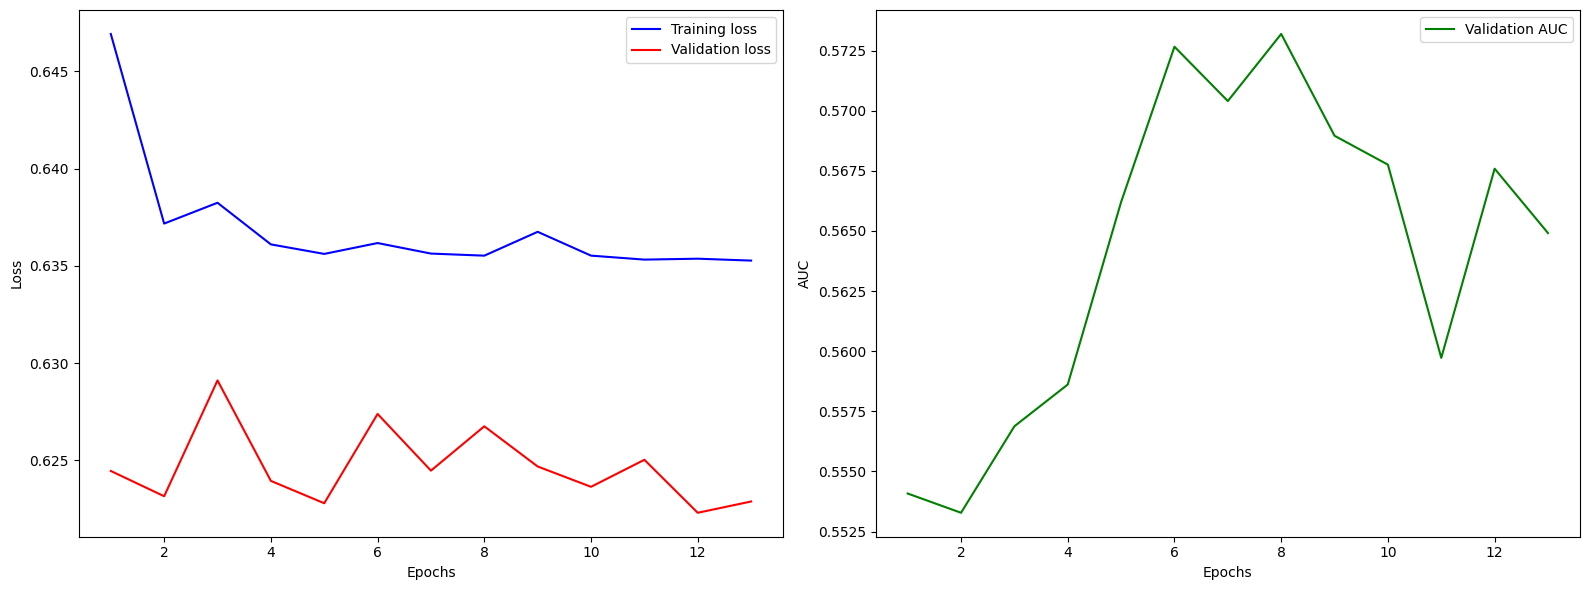

In [ ]:
best_params = {'hidden_dim': 64,
 'layer_dim': 2,
 'dropout_prob': 0.0,
 'learning_rate': 0.001,
 'batch_size': 64,
 'num_epochs': 40,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 1e-05}

### **Train the final model**

In [ ]:
# Load the test sequences
low_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_test_sequences_v1.npy'
medium_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/medium_df_test_sequences_v1.npy'
high_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/high_df_test_sequences_v1.npy'

# Load the test labels
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_df_test_labels_v1.npy'

low_freq_test_sequences = np.load(low_test_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_test_sequences = np.load(medium_test_seq_path, allow_pickle=True).astype(np.float32)
high_freq_test_sequences = np.load(high_test_seq_path, allow_pickle=True).astype(np.float32)

labels_test = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

print(f'Low frequency test sequences shape: {low_freq_test_sequences.shape}')
print(f'Medium frequency test sequences shape: {medium_freq_test_sequences.shape}')
print(f'High frequency test sequences shape: {high_freq_test_sequences.shape}')
print(f'Test labels shape: {labels_test.shape}')

Low frequency test sequences shape: (941, 4, 3)
Medium frequency test sequences shape: (941, 7, 5)
High frequency test sequences shape: (941, 13, 2)
Test labels shape: (941,)


In [ ]:
final_model = FusedLSTMModel(
    low_input_dim=low_freq_train_sequences.shape[2],
    medium_input_dim=medium_freq_train_sequences.shape[2],
    high_input_dim=high_freq_train_sequences.shape[2],
    hidden_dim=best_params['hidden_dim'],
    layer_dim=best_params['layer_dim'],
    output_dim=1,
    dropout_prob=best_params['dropout_prob']
).to(device)

final_model

FusedLSTMModel(
  (low_lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (medium_lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (high_lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'oversample':
  train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = oversample_data(
      low_freq_train_sequences, labels_train,
      medium_freq_train_sequences, high_freq_train_sequences)
elif best_params['sampling_method'] == 'undersample':
  train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = undersample_data(
      low_freq_train_sequences, labels_train,
      medium_freq_train_sequences, high_freq_train_sequences)
else:
  train_low_sequences_resampled, train_labels_resampled = low_freq_train_sequences, labels_train
  train_medium_sequences_resampled, train_high_sequences_resampled = medium_freq_train_sequences, high_freq_train_sequences

# Define the loss function
if best_params['loss'] == 'weighted':
  pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimizer with learning rate and L2 weight decay
optimizer = optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Move the model to the device
# final_model = final_model.to(device)

# Create data loaders
train_loader, _ , test_loader = create_multi_input_data_loaders(
    train_low_sequences_resampled,
    train_medium_sequences_resampled,
    train_high_sequences_resampled,
    train_labels_resampled,
    _,
    _,
    _,
    _,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    batch_size=best_params['batch_size']
)

NameError: name 'final_model' is not defined

In [ ]:
# Create data loaders
train_loader, _ , test_loader = create_multi_input_data_loaders(
    train_low_sequences_resampled,
    train_medium_sequences_resampled,
    train_high_sequences_resampled,
    train_labels_resampled,
    _,
    _,
    _,
    _,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    batch_size=best_params['batch_size']
)

**Train the final model**

In [ ]:
# Train the final model on the whole training set
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    return model, train_losses

In [ ]:
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device
)

Epoch 1/40, Loss: 0.6422
Epoch 2/40, Loss: 0.6311
Epoch 3/40, Loss: 0.6294
Epoch 4/40, Loss: 0.6244
Epoch 5/40, Loss: 0.6213
Epoch 6/40, Loss: 0.6202
Epoch 7/40, Loss: 0.6235
Epoch 8/40, Loss: 0.6180
Epoch 9/40, Loss: 0.6180
Epoch 10/40, Loss: 0.6165
Epoch 11/40, Loss: 0.6176
Epoch 12/40, Loss: 0.6135
Epoch 13/40, Loss: 0.6116
Epoch 14/40, Loss: 0.6124
Epoch 15/40, Loss: 0.6117
Epoch 16/40, Loss: 0.6103
Epoch 17/40, Loss: 0.6099
Epoch 18/40, Loss: 0.6110
Epoch 19/40, Loss: 0.6094
Epoch 20/40, Loss: 0.6084
Epoch 21/40, Loss: 0.6111
Epoch 22/40, Loss: 0.6101
Epoch 23/40, Loss: 0.6098
Epoch 24/40, Loss: 0.6082
Epoch 25/40, Loss: 0.6090
Epoch 26/40, Loss: 0.6091
Epoch 27/40, Loss: 0.6091
Epoch 28/40, Loss: 0.6085
Epoch 29/40, Loss: 0.6099
Epoch 30/40, Loss: 0.6100
Epoch 31/40, Loss: 0.6083
Epoch 32/40, Loss: 0.6077
Epoch 33/40, Loss: 0.6085
Epoch 34/40, Loss: 0.6070
Epoch 35/40, Loss: 0.6075
Epoch 36/40, Loss: 0.6070
Epoch 37/40, Loss: 0.6093
Epoch 38/40, Loss: 0.6070
Epoch 39/40, Loss: 0.

In [ ]:
# Save final model
output_dir = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/04_lstm_model_fused_decision/best_models/experiment_1/final_model.pkl'

with open(output_dir, 'wb') as f:
    pickle.dump(final_model, f)

# Save best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/04_lstm_model_fused_decision/best_models/experiment_1/best_params.json'

with open(params_path, 'w') as f:
    json.dump(best_params, f)

### **Evaluate the final model**

In [ ]:
# Load the final model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/04_lstm_model_fused_decision/dynamic_data/best_models/experiment_1/final_model.pkl'

with open(model_path, 'rb') as f:
    final_model = pickle.load(f)

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The neural network model to be evaluated.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to evaluate the model on.

    Returns:
    tuple: A tuple containing the evaluation metrics (accuracy, precision, recall, f1, roc_auc, specificity).
    """
    model.to(device)
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return (accuracy, precision, recall, f1, roc_auc, specificity), (test_outputs, test_labels)

In [ ]:
# Evaluate the final model
_, (predictions, labels) = evaluate_model(final_model, test_loader, device)

Accuracy: 0.6982
Precision: 0.6812
Recall (Sensitivity): 0.1521
F1 Score: 0.2487
ROC AUC: 0.6567
Specificity: 0.9652


Accuracy: 0.6982
Precision: 0.6812
Recall (Sensitivity): 0.1521
F1 Score: 0.2487
ROC AUC: 0.6567
Specificity: 0.9652
(0.6981934112646121,
 0.6811594202898551,
 0.15210355987055016,
 0.24867724867724866,
 0.6567377411822539,
 0.9651898734177216)

In [ ]:
# Save the predictions for ensemble methods
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/04_lstm_model_fused_decision/dynamic_data/best_models/experiment_1/predictions.npy', predictions)

The model performs better than the previous LSTM iteration on an ROC AUC basis and Accuracy but not on recall.

We can analyse these results further

**Calculate the F1 on the minority class**

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

In [ ]:
calculate_f1_minority(final_model, test_loader, device)

0.24867724867724866

The F1 on the extubation failure class is much lower than the simpler LSTM model.

This suggests that the model complexity could lead to over or underfitting. This might be the case as the lower frequency layers had significantly less data to learn from.

Hyperparameter Tuning: The fused model might require different hyperparameters compared to the simpler LSTM. Parameters such as learning rate, batch size, number of layers, dropout rate, and hidden dimensions might need to be adjusted specifically for the fused architecture.

Integration of Multi-Frequency Data: The way different frequency sequences are fused might not be optimal. The model might struggle to effectively combine information from different frequency sequences if they are not properly aligned or if the fusion strategy is not appropriate.

**Confusion Matrix**

We can see what the confusion matrix looks like for this model.

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_test_sequences = data['low_freq_sequence'].to(device)
            medium_freq_test_sequences = data['medium_freq_sequence'].to(device)
            high_freq_test_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['extubation_success', 'extubation_failure']  # Replace with your actual class names if different

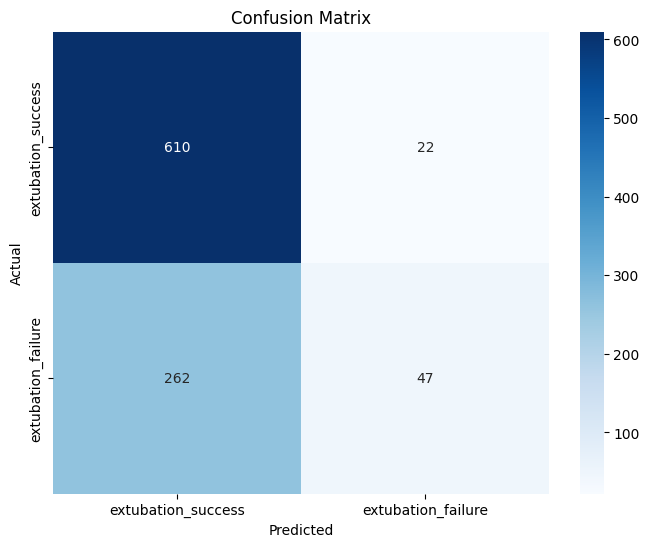

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

The majority of predictions are on the extubation_success category. However, in contrast to the simpler model, not all predictions are on one class.

**Classification threshold**

We can see whether there is a better classification threshold than 0.5 which is the standard currently used.

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, test_loader, device):
    """
    Find the best threshold for binary classification based on F1 score and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    dict: A dictionary containing the best threshold, F1 score, and other evaluation metrics.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    best_threshold = 0.5
    best_f1_score = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        f1 = f1_score(all_labels, preds)

        if f1 > best_f1_score:
            best_f1_score = f1
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_f1_score': best_f1_score,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best F1 Score: {best_f1_score}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
find_best_threshold_and_evaluate(final_model, test_loader, device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:911: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1424.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


Best Threshold: 0.29
Best F1 Score: 0.5213581599123768
Accuracy: 0.5356
Precision: 0.3940
Recall: 0.7702
F1 Score: 0.5214
ROC AUC: 0.6567
Specificity: 0.4209


{'best_threshold': 0.29,
 'best_f1_score': 0.5213581599123768,
 'accuracy': 0.5356004250797024,
 'precision': 0.39403973509933776,
 'recall': 0.7702265372168284,
 'f1_score': 0.5213581599123768,
 'roc_auc': 0.6567377411822539,
 'specificity': 0.4208860759493671}

The best threshold is biased towards the extubation success category.

The accuracy and precision is lower and the ROC AUC is not significantly higher. (WHAT DOES IT MEAN IF THE BEST THRESHOLD HAS LITTLE IMPACT)

**Plot ROC curve**

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_curve

def plot_roc_curve(model, test_loader, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc_score(all_labels, all_probs)))
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


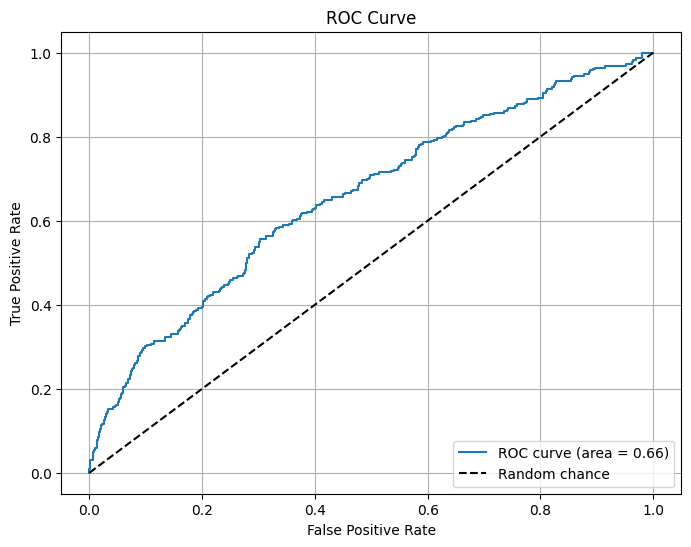

In [ ]:
plot_roc_curve(final_model, test_loader, device)

The curve is better than the straight line shown for the simpler architecture.

### **Model Interpretability**

We can now implement feature ablation.

In [ ]:
# Load the feature names
low_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/low_freq_feature_names_v1.npy'
medium_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/medium_freq_feature_names_v1.npy'
high_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/feature_subsets_run_2/high_freq_feature_names_v1.npy'

low_freq_feature_names = np.load(low_feature_names, allow_pickle=True)
medium_freq_feature_names = np.load(medium_feature_names, allow_pickle=True)
high_freq_feature_names = np.load(high_feature_names, allow_pickle=True)

print(low_freq_feature_names)
print(medium_freq_feature_names)
print(high_freq_feature_names)

['PH (Arterial)' 'Arterial CO2 Pressure' 'Arterial O2 pressure']
['Inspired O2 Fraction' 'Tidal Volume (observed)' 'Minute Volume'
 'Peak Insp. Pressure' 'Tidal Volume (spontaneous)']
['O2 saturation pulseoxymetry' 'Respiratory Rate']


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
def feature_ablation_with_names(low_train_sequences, medium_train_sequences, high_train_sequences, train_labels,
                                low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
                                model, best_hyperparams, device, low_feature_names, medium_feature_names, high_feature_names):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    low_train_sequences (np.array): The low frequency training sequences.
    medium_train_sequences (np.array): The medium frequency training sequences.
    high_train_sequences (np.array): The high frequency training sequences.
    train_labels (np.array): The training labels.
    low_test_sequences (np.array): The low frequency test sequences.
    medium_test_sequences (np.array): The medium frequency test sequences.
    high_test_sequences (np.array): The high frequency test sequences.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained fused LSTM model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    low_feature_names (list): List of low frequency feature names.
    medium_feature_names (list): List of medium frequency feature names.
    high_feature_names (list): List of high frequency feature names.

    Returns:
    feature_importances (pd.DataFrame): DataFrame containing the importance of each feature.
    """
    feature_importances = {}

    criterion = nn.BCELoss()
    test_loader = create_multi_input_data_loaders(
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        best_hyperparams['batch_size']
    )[2]  # Only get the test loader

    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model, test_loader, criterion, device
    )

    def ablate_and_evaluate(train_sequences, test_sequences, feature_names, subset):
        for feature_idx in range(train_sequences.shape[2]):
            feature_name = feature_names[feature_idx]
            print(f"Ablating feature {feature_name} ({feature_idx + 1}/{train_sequences.shape[2]})")

            # Remove the feature from the sequences
            train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
            test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

            if subset == 0:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    train_sequences_ablation, medium_train_sequences, high_train_sequences, train_labels,
                    train_sequences_ablation, medium_train_sequences, high_train_sequences, train_labels,
                    test_sequences_ablation, medium_test_sequences, high_test_sequences, test_labels,
                    best_hyperparams['batch_size']
                )
            elif subset == 1:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    low_train_sequences, train_sequences_ablation, high_train_sequences, train_labels,
                    low_train_sequences, train_sequences_ablation, high_train_sequences, train_labels,
                    low_test_sequences, test_sequences_ablation, high_test_sequences, test_labels,
                    best_hyperparams['batch_size']
                )
            else:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    low_train_sequences, medium_train_sequences, train_sequences_ablation, train_labels,
                    low_train_sequences, medium_train_sequences, train_sequences_ablation, train_labels,
                    low_test_sequences, medium_test_sequences, test_sequences_ablation, test_labels,
                    best_hyperparams['batch_size']
                )

            # Initialize a new model for this ablation
            ablation_model = FusedLSTMModel(
                low_input_dim=low_train_sequences.shape[2] - (1 if subset == 0 else 0),
                medium_input_dim=medium_train_sequences.shape[2] - (1 if subset == 1 else 0),
                high_input_dim=high_train_sequences.shape[2] - (1 if subset == 2 else 0),
                hidden_dim=best_hyperparams['hidden_dim'],
                layer_dim=best_hyperparams['layer_dim'],
                output_dim=1,
                dropout_prob=best_hyperparams['dropout_prob']
            ).to(device)

            optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

            # Train the model
            ablation_model, _, _, _ = train_fused_model_with_early_stopping_logging(
                ablation_model, train_loader, val_loader, criterion, optimizer,
                best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
            )

            # Evaluate the model
            _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

            feature_importances[feature_name] = {
                'accuracy': base_accuracy - accuracy,
                'precision': base_precision - precision,
                'recall': base_recall - recall,
                'f1': base_f1 - f1,
                'roc_auc': base_roc_auc - roc_auc,
                'specificity': base_specificity - specificity
            }

    ablate_and_evaluate(low_train_sequences, low_test_sequences, low_feature_names, 0)
    ablate_and_evaluate(medium_train_sequences, medium_test_sequences, medium_feature_names, 1)
    ablate_and_evaluate(high_train_sequences, high_test_sequences, high_feature_names, 2)

    # Convert feature importances to a DataFrame for better readability
    feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index')
    feature_importances_df = feature_importances_df.sort_values(by='roc_auc', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances_df.index, feature_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return feature_importances_df

Ablating feature PH (Arterial) (1/3)
Epoch 0/39, Loss: 0.6395, Val Loss: 0.6339, Val AUC: 0.5443
Epoch 1/39, Loss: 0.6329, Val Loss: 0.6304, Val AUC: 0.5686
Epoch 2/39, Loss: 0.6285, Val Loss: 0.6274, Val AUC: 0.5832
Epoch 3/39, Loss: 0.6277, Val Loss: 0.6258, Val AUC: 0.5795
Epoch 4/39, Loss: 0.6224, Val Loss: 0.6209, Val AUC: 0.5868
Epoch 5/39, Loss: 0.6207, Val Loss: 0.6194, Val AUC: 0.5920
Epoch 6/39, Loss: 0.6195, Val Loss: 0.6174, Val AUC: 0.6022
Epoch 7/39, Loss: 0.6185, Val Loss: 0.6130, Val AUC: 0.6035
Epoch 8/39, Loss: 0.6147, Val Loss: 0.6123, Val AUC: 0.6056
Epoch 9/39, Loss: 0.6153, Val Loss: 0.6112, Val AUC: 0.6120
Epoch 10/39, Loss: 0.6135, Val Loss: 0.6091, Val AUC: 0.6171
Epoch 11/39, Loss: 0.6115, Val Loss: 0.6090, Val AUC: 0.6221
Epoch 12/39, Loss: 0.6105, Val Loss: 0.6104, Val AUC: 0.6225
Epoch 13/39, Loss: 0.6122, Val Loss: 0.6069, Val AUC: 0.6234
Epoch 14/39, Loss: 0.6083, Val Loss: 0.6123, Val AUC: 0.6231
Epoch 15/39, Loss: 0.6075, Val Loss: 0.6079, Val AUC: 0.62

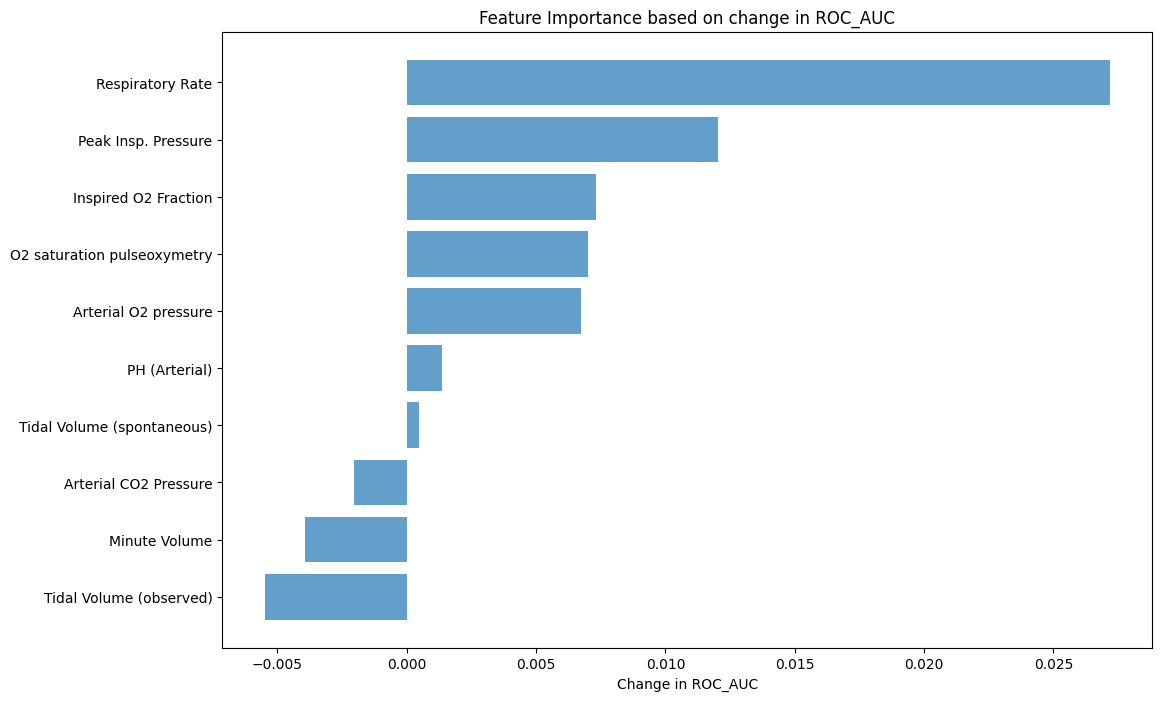

In [ ]:
# Execute feature ablation
feature_importances_df = feature_ablation_with_names(
    train_low_sequences_resampled,
    train_medium_sequences_resampled,
    train_high_sequences_resampled,
    train_labels_resampled,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    final_model,
    best_params,
    device,
    low_freq_feature_names,
    medium_freq_feature_names,
    high_freq_feature_names
)

**SHAP**

**LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=da7fb9cb2286090d544918e3469665882eddf0dddbd315baa5d5ca8cf75b9cf1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import numpy as np

def predict_fn(inputs, model):
    # Ensure the model is in evaluation mode
    model.eval()

    # Assuming inputs are provided as a list of numpy arrays (for low, medium, high frequency data)
    low_x = torch.tensor(inputs[0], dtype=torch.float32).to(device)
    medium_x = torch.tensor(inputs[1], dtype=torch.float32).to(device)
    high_x = torch.tensor(inputs[2], dtype=torch.float32).to(device)

    with torch.no_grad():
        # Perform the forward pass through the model
        outputs = model(low_x, medium_x, high_x)

    # Convert outputs to probabilities (if not already)
    probs = torch.sigmoid(outputs).cpu().numpy()
    return np.hstack([1 - probs, probs])  # LIME expects a 2D array with probabilities for each class


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
# Flatten each sequence along the time dimension
train_low_sequences_flattened = train_low_sequences_resampled.reshape(train_low_sequences_resampled.shape[0], -1)
train_medium_sequences_flattened = train_medium_sequences_resampled.reshape(train_medium_sequences_resampled.shape[0], -1)
train_high_sequences_flattened = train_high_sequences_resampled.reshape(train_high_sequences_resampled.shape[0], -1)

In [ ]:
# Concatenate the flattened sequences
train_sequences_combined = np.hstack((train_low_sequences_flattened, train_medium_sequences_flattened, train_high_sequences_flattened))

# Concatenate the feature names
combined_feature_names = (
    [f'{name}_t{i}' for name in low_freq_feature_names for i in range(low_freq_train_sequences.shape[1])] +
    [f'{name}_t{i}' for name in medium_freq_feature_names for i in range(medium_freq_train_sequences.shape[1])] +
    [f'{name}_t{i}' for name in high_freq_feature_names for i in range(high_freq_train_sequences.shape[1])]
)

In [ ]:
print("Shape of train_sequences_combined:", train_sequences_combined.shape)
print("Length of combined_feature_names:", len(combined_feature_names))

Shape of train_sequences_combined: (3760, 73)
Length of combined_feature_names: 73


In [ ]:
explainer = LimeTabularExplainer(
    training_data=train_sequences_combined,
    feature_names=combined_feature_names,
    class_names=['extubation_success', 'extubation_failure'],
    mode='classification',
    discretize_continuous=False
)

Now we need to choose an instance to explain.

In [ ]:
# Flatten and concatenate all frequency features
instance_to_explain = np.hstack((
    low_freq_test_sequences[0].flatten(),    # Flatten the low-frequency features
    medium_freq_test_sequences[0].flatten(), # Flatten the medium-frequency features
    high_freq_test_sequences[0].flatten()    # Flatten the high-frequency features
))

In [ ]:
# Generate the explanation for the instance
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=lambda x: predict_fn([x], final_model),
    num_features=10,  # Number of features to explain
    top_labels=1  # Number of top labels to consider§
)

ValueError: Input contains NaN.

In [ ]:
# Concatenate the flattened sequences
train_sequences_combined = np.hstack((train_low_sequences_flattened, train_medium_sequences_flattened, train_high_sequences_flattened))

# Concatenate the feature names
combined_feature_names = (
    [f'{name}_t{i}' for name in low_freq_feature_names for i in range(low_freq_train_sequences.shape[1])] +
    [f'{name}_t{i}' for name in medium_freq_feature_names for i in range(medium_freq_train_sequences.shape[1])] +
    [f'{name}_t{i}' for name in high_freq_feature_names for i in range(high_freq_train_sequences.shape[1])]
)

LIME cannot handle data where there are NaN values. To apply LIME we will need to imput  these NaN values accordingly - however, this is not ideal as throughout we have been trying to limit the amount of inputation needed.

As such we will try masking.

In [ ]:
def predict_with_masking(data, model):
    # Assuming data is a 2D array where each row is an instance
    data = np.array(data)

    # Split the data back into low, medium, and high frequency components
    low_data, medium_data, high_data = np.split(data, indices_or_sections=[3 * low_freq_test_sequences.shape[1], 3 * low_freq_test_sequences.shape[1] + 5 * medium_freq_test_sequences.shape[1]], axis=1)

    # Mask NaNs with zeros before feeding into the model
    low_data = np.nan_to_num(low_data.reshape(low_data.shape[0], low_freq_test_sequences.shape[1], -1))
    medium_data = np.nan_to_num(medium_data.reshape(medium_data.shape[0], medium_freq_test_sequences.shape[1], -1))
    high_data = np.nan_to_num(high_data.reshape(high_data.shape[0], high_freq_test_sequences.shape[1], -1))

    # Convert to tensors and move to the correct device
    low_data_tensor = torch.tensor(low_data, dtype=torch.float32).to(device)
    medium_data_tensor = torch.tensor(medium_data, dtype=torch.float32).to(device)
    high_data_tensor = torch.tensor(high_data, dtype=torch.float32).to(device)

    # Perform prediction
    with torch.no_grad():
        outputs = model(low_data_tensor, medium_data_tensor, high_data_tensor)
        predictions = outputs.cpu().numpy()

    return predictions


In [ ]:
# Mask NaNs with zeros (or any other value) before combining sequences
train_low_sequences_masked = np.nan_to_num(train_low_sequences_resampled)
train_medium_sequences_masked = np.nan_to_num(train_medium_sequences_resampled)
train_high_sequences_masked = np.nan_to_num(train_high_sequences_resampled)

# Combine the sequence data into a single array after masking
train_sequences_combined = np.hstack((
    train_low_sequences_masked.reshape(train_low_sequences_masked.shape[0], -1),
    train_medium_sequences_masked.reshape(train_medium_sequences_masked.shape[0], -1),
    train_high_sequences_masked.reshape(train_high_sequences_masked.shape[0], -1)
))

In [ ]:
# Create an instance to explain and mask NaNs with zeros
instance_to_explain = np.hstack((
    np.nan_to_num(low_freq_test_sequences[0].reshape(-1)),
    np.nan_to_num(medium_freq_test_sequences[0].reshape(-1)),
    np.nan_to_num(high_freq_test_sequences[0].reshape(-1))
))

In [ ]:
# Initialize the LIME explainer
explainer = LimeTabularExplainer(
    training_data=train_sequences_combined,
    feature_names=combined_feature_names,
    class_names=['extubation_success', 'extubation_failure'],
    mode='classification',
    discretize_continuous=False
)

In [ ]:
# Generate the explanation for the instance
explanation = explainer.explain_instance(
    data_row=instance_to_explain,
    predict_fn=lambda x: predict_with_masking(x, final_model),
    num_features=10,  # Number of features to explain
    top_labels=1  # Number of top labels to consider
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# **Addendum: Trying other interpretability techniques**

SHAP is unlikely to work with a custom architecture such as our Fused LSTM model. As such, we will try other techniques as outlined in: https://link.springer.com/article/10.1007/s10462-022-10304-3

**DeepLIFT**

DeepLIFT is a post-hoc explanation of deep networks. Similar to SHAP it provides a score for each feature to analyse network outcomes.

In [ ]:
!pip install captum

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from captum.attr import DeepLift
from captum.attr import visualization as viz

In [ ]:
# Load the final model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/04_lstm_model_fused_decision/dynamic_data/best_models/experiment_1/final_model.pkl'

with open(model_path, 'rb') as f:
    final_model = pickle.load(f)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
final_model.to(device)

FusedLSTMModel(
  (low_lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (medium_lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (high_lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
final_model.eval()

FusedLSTMModel(
  (low_lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (medium_lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (high_lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# Initialise DeepLIFT
deeplift = DeepLift(final_model)

In [ ]:
# Convert sequences to tensors
low_freq_test_sequences_tensor = torch.tensor(low_freq_test_sequences, dtype=torch.float32, requires_grad=True).to(device)
medium_freq_test_sequences_tensor = torch.tensor(medium_freq_test_sequences, dtype=torch.float32, requires_grad=True).to(device)
high_freq_test_sequences_tensor = torch.tensor(high_freq_test_sequences, dtype=torch.float32, requires_grad=True).to(device)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.int64).to(device)

In [ ]:
# Calculate the attribution scores
attributions = deeplift.attribute(
    inputs=(low_freq_test_sequences_tensor, medium_freq_test_sequences_tensor, high_freq_test_sequences_tensor),
    target=labels_test_tensor
)

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


DeepLIFT does not seem to work with a more complex model architecture.

**Integrated Gradients**

In [ ]:
from captum.attr import IntegratedGradients

In [ ]:
final_model.eval()
final_model.to(device)

FusedLSTMModel(
  (low_lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (medium_lstm): LSTM(5, 64, num_layers=2, batch_first=True)
  (high_lstm): LSTM(2, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=192, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
low_freq_test_sequences_tensor = torch.tensor(low_freq_test_sequences, dtype=torch.float32, requires_grad=True).to(device)
medium_freq_test_sequences_tensor = torch.tensor(medium_freq_test_sequences, dtype=torch.float32, requires_grad=True).to(device)
high_freq_test_sequences_tensor = torch.tensor(high_freq_test_sequences, dtype=torch.float32, requires_grad=True).to(device)
labels_test_tensor = torch.tensor(labels_test, dtype=torch.int64).to(device)

In [ ]:
integrated_gradients = IntegratedGradients(final_model)

In [ ]:
# Calculate the attribution scores
attributions = integrated_gradients.attribute(
    inputs=(low_freq_test_sequences_tensor, medium_freq_test_sequences_tensor, high_freq_test_sequences_tensor),
    target=labels_test_tensor
)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


It seems there is an issue with captum imports and adapting it for our model. As such, we will try and do Integrated GRadients manually.

In [ ]:
import torch

def integrated_gradients(inputs, model, target_label_idx, baseline=None, steps=50):
    if baseline is None:
        # Use a baseline of all zeros if none is provided
        baseline = torch.zeros_like(inputs)

    # Scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    scaled_inputs = torch.stack(scaled_inputs).to(inputs.device)

    # Initialize gradients
    accumulated_gradients = torch.zeros_like(inputs).to(inputs.device)

    for i in range(steps):
        # Forward pass
        scaled_input = scaled_inputs[i].unsqueeze(0)
        scaled_input.requires_grad_()

        output = model(scaled_input)
        output = output[0, target_label_idx]

        # Backward pass
        model.zero_grad()
        output.backward(retain_graph=True)

        # Accumulate gradients
        accumulated_gradients += scaled_input.grad.data

    # Average accumulated gradients and compute integrated gradients
    avg_gradients = accumulated_gradients / steps
    integrated_grads = (inputs - baseline) * avg_gradients

    return integrated_grads


In [ ]:
# Ensure inputs are on the correct device
low_freq_test_sequences_tensor = low_freq_test_sequences_tensor.to(device)
medium_freq_test_sequences_tensor = medium_freq_test_sequences_tensor.to(device)
high_freq_test_sequences_tensor = high_freq_test_sequences_tensor.to(device)

# Example: Compute integrated gradients for a specific instance and target label
target_label_idx = 0  # Index of the target label (adjust based on your problem)
ig_low = integrated_gradients(low_freq_test_sequences_tensor[0], final_model, target_label_idx)
ig_medium = integrated_gradients(medium_freq_test_sequences_tensor[0], final_model, target_label_idx)
ig_high = integrated_gradients(high_freq_test_sequences_tensor[0], final_model, target_label_idx)

# Convert integrated gradients to numpy for analysis or visualization
ig_low_np = ig_low.detach().cpu().numpy()
ig_medium_np = ig_medium.detach().cpu().numpy()
ig_high_np = ig_high.detach().cpu().numpy()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
